In [1]:
import os
import glob
import sys

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
base_path = '../experiments/'
model = 'densenet'

METHODS = {
#     "ig": "ig",
    "sailency": "sailency",
    "gradcam": "gradcam",
    "deconv": "deconv",
    "gbp": "gbp",
}

SPLIT_OPTIONS = ["100%", "80%", "60%", "40%", "20%"]

DATASETS = {
    "edible-plants": "edible-plants",
    "food101": "food101",
    "marvel": "marvel",
    "plant-data": "plant-data",
    "stanford-dogs": "stanford-dogs",
}
ACC = {}
F1 = {}


fig_size = (30,16)
title_font=32
label_font=28
marker_size=18

plt.rcParams.update({'font.size': 22})

In [3]:
for dataset in DATASETS.keys():
    for data_split in SPLIT_OPTIONS:
        path = os.path.join('../models/evals', f"{model}-{dataset}-{data_split}.csv")
        res_df = pd.read_csv(path, names=['f1', 'acc'])        
        
        if dataset not in ACC:
            ACC[dataset] = {}
        if dataset not in F1:
            F1[dataset] = {}
        
        ACC[dataset][data_split] = float(res_df['acc'])
        F1[dataset][data_split] = float(res_df['f1'])

In [4]:
preds = pd.DataFrame()
for dataset in DATASETS.keys():
    for data_split in SPLIT_OPTIONS:
        path = os.path.join('../models/evals', f"{model}-{dataset}-{data_split}-scores.csv")
        res_df = pd.read_csv(path)  
        
        if dataset == DATASETS["food101"]:
            res_df = res_df.iloc[::5, :].reset_index()
        if dataset == DATASETS["stanford-dogs"]:
            res_df = res_df.iloc[::2, :].reset_index()
        if dataset == DATASETS["plant-data"]:
            res_df = res_df.iloc[::2, :].reset_index()
            
        res_df["dataset"] = dataset
        res_df["data_split"] = data_split

        for method in METHODS.keys():
            res_path = os.path.join(base_path, dataset, f"{model}-{data_split}", method, f"{model}-{dataset}-{method}.csv")
            method_df = pd.read_csv(res_path)
            res_df[f"{method}-infidelity"] = method_df["# infidelity"]
            res_df[f"{method}-sensitivity"] = method_df["sensitivity"]
        
        print(f"{model}-{dataset}-{data_split} {len(res_df)}")
        preds = preds.append(res_df, ignore_index=True)
        
print(preds.head(10))
print(preds.describe())


densenet-edible-plants-100% 310
densenet-edible-plants-80% 310
densenet-edible-plants-60% 310
densenet-edible-plants-40% 310
densenet-edible-plants-20% 310
densenet-food101-100% 5050
densenet-food101-80% 5050
densenet-food101-60% 5050
densenet-food101-40% 5050
densenet-food101-20% 5050
densenet-marvel-100% 451
densenet-marvel-80% 451
densenet-marvel-60% 451
densenet-marvel-40% 451
densenet-marvel-20% 451
densenet-plant-data-100% 2609
densenet-plant-data-80% 2609
densenet-plant-data-60% 2609
densenet-plant-data-40% 2609
densenet-plant-data-20% 2609
densenet-stanford-dogs-100% 2081
densenet-stanford-dogs-80% 2081
densenet-stanford-dogs-60% 2081
densenet-stanford-dogs-40% 2081
densenet-stanford-dogs-20% 2081
   Unnamed: 0  true  pred  currect     score        dataset data_split  \
0           0   0.0   0.0      1.0  0.990296  edible-plants       100%   
1           1   0.0   0.0      1.0  0.997745  edible-plants       100%   
2           2   0.0   0.0      1.0  0.983673  edible-plants    

In [5]:
scores = []
for dataset in DATASETS.keys():
    for method in METHODS.keys():
        for data_split in SPLIT_OPTIONS:
            path = os.path.join(base_path, dataset, f"{model}-{data_split}", method, f"{model}-{dataset}-{method}.csv")
            df = pd.read_csv(path)
            df = df.mean(axis=0)
            scores.append([model, dataset, data_split, method, ACC[dataset][data_split], F1[dataset][data_split], df['# infidelity'], df['sensitivity']])
       

In [6]:
scores_df = pd.DataFrame(np.array(scores), columns=['model', 'dataset', 'data_split', 'method', 'acc', 'f1', 'infidelity', 'sensitivity'])
scores_df['acc'] = scores_df['acc'].map(lambda x: float(x))
scores_df['f1'] = scores_df['f1'].map(lambda x: float(x))

In [7]:
scores_df[(scores_df['method'] == 'gbp') & (scores_df['data_split'] == '20%')]

model        dataset data_split method     acc      f1  \
19  densenet  edible-plants        20%    gbp  0.6576  0.5957   
39  densenet        food101        20%    gbp  0.7585  0.7555   
59  densenet         marvel        20%    gbp  0.6777  0.6582   
79  densenet     plant-data        20%    gbp  0.7494  0.7397   
99  densenet  stanford-dogs        20%    gbp  0.7932  0.7846   

                infidelity         sensitivity  
19    0.000300127311575418   1.174010585008129  
39   0.0014139528648027607   1.244114464190927  
59  0.00046957851750519333  1.1244334431815306  
79   0.0005690235209128627  1.1292685037510932  
99   0.0024632893221449813  1.2936358416899645

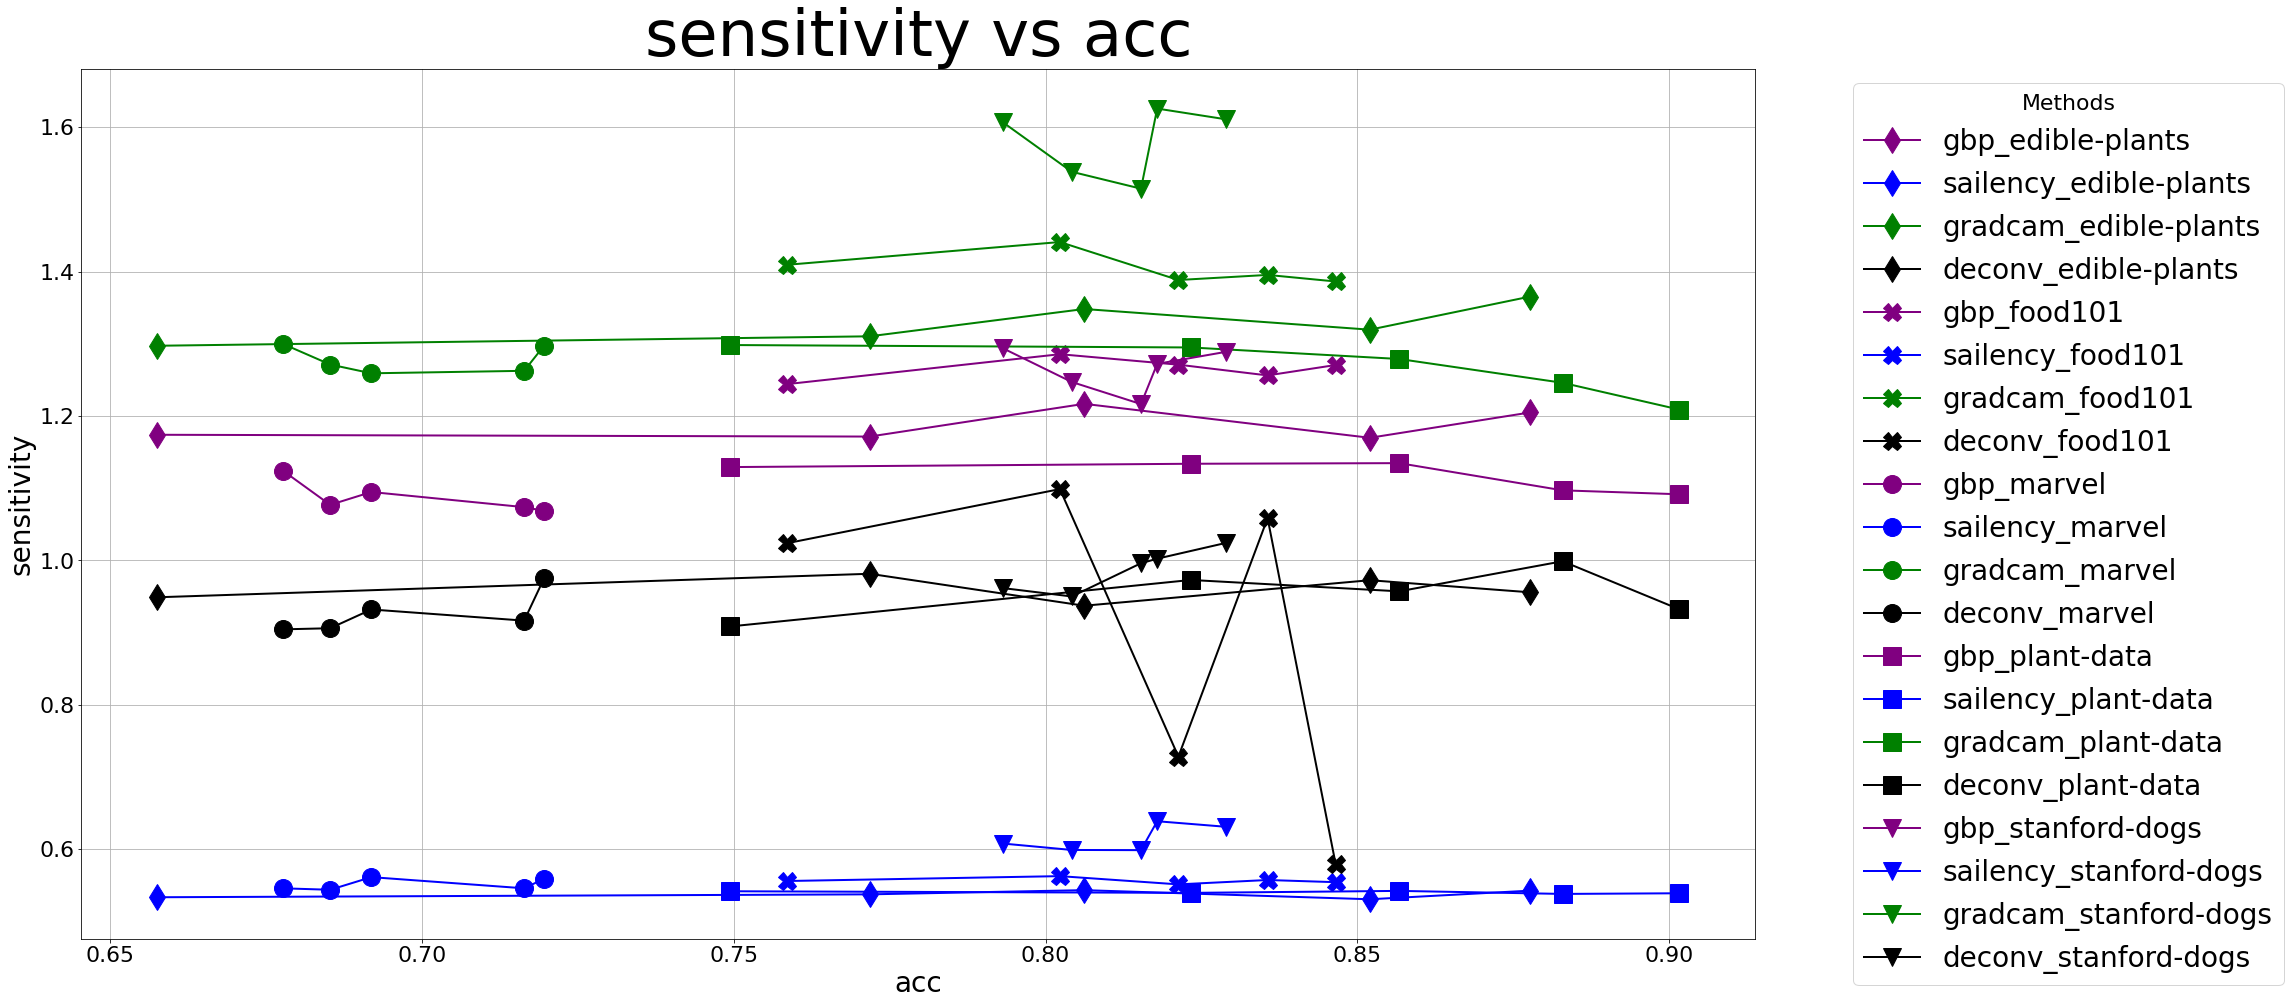

In [18]:
COLORS = {
#     "ig": "red",
    "sailency": "blue",
    "gradcam": "green",
    "deconv": "black",
    "gbp": "purple",
}
MARKERS = {
    "edible-plants": "d",
    "food101": "X",
    "marvel": "o",
    "plant-data": "s",
    "stanford-dogs": "v",
}
methods = [
#     'ig',
    'gbp',
    'sailency',
    'gradcam',
    'deconv'
]
fig = plt.figure(figsize=fig_size) 

for dataset in DATASETS.keys():
    for method in methods:
        filter_df = scores_df[(scores_df['method'] == method) & (scores_df['dataset'] == dataset)].sort_values(['acc'])
        filter_df['sensitivity'] = filter_df['sensitivity'].map(lambda x: float(x))

        plt.plot(filter_df['acc'], filter_df['sensitivity'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset, linewidth=2, markersize=marker_size)
    
plt.title('sensitivity vs acc', fontsize=title_font)
plt.xlabel('acc', fontsize=label_font)
plt.ylabel('sensitivity', fontsize=label_font)
plt.legend( title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=label_font)
plt.grid(True)
fig.savefig(f'../prints/{model}-sensitivity vs acc.jpg', bbox_inches='tight')
fig.savefig(f'../prints/{model}-sensitivity vs acc.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=fig_size) 

for dataset in DATASETS.keys():
    for method in methods:
        filter_df = scores_df[(scores_df['method'] == method) & (scores_df['dataset'] == dataset)].sort_values(['f1'])
        filter_df['sensitivity'] = filter_df['sensitivity'].map(lambda x: float(x))

        plt.plot(filter_df['f1'], filter_df['sensitivity'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset, linewidth=2, markersize=marker_size)
    
plt.title('sensitivity vs f1-score', fontsize=title_font)
plt.xlabel('weighted f1', fontsize=label_font)
plt.ylabel('sensitivity', fontsize=label_font)
plt.legend( title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=label_font)
plt.grid(True)
plt.show()

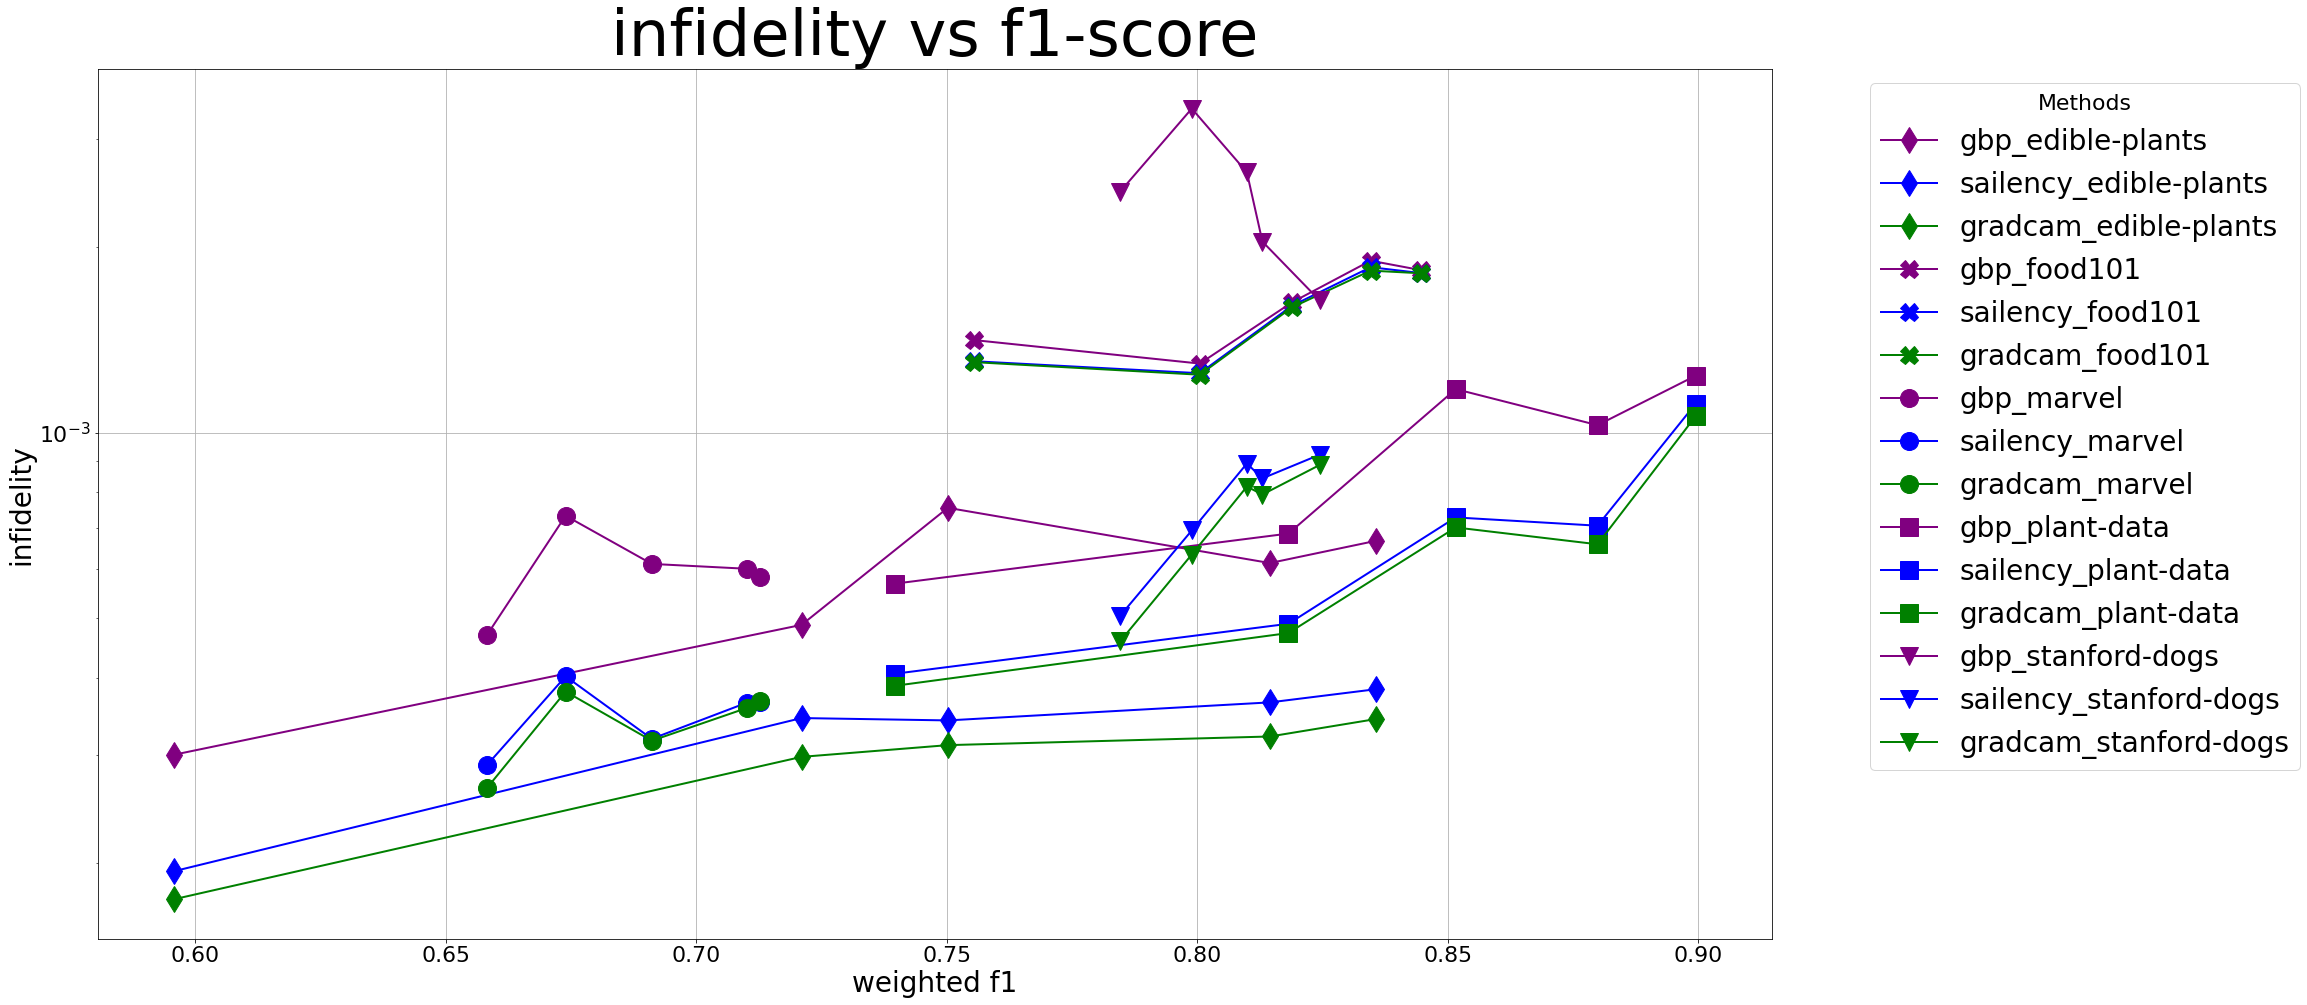

In [16]:

methods = [
#     'ig',
    'gbp',
    'sailency',
    'gradcam',
#     'deconv'
]
fig = plt.figure(figsize=fig_size) 
for dataset in DATASETS.keys():
    for method in methods:
        filter_df = scores_df[(scores_df['method'] == method) & (scores_df['dataset'] == dataset)].sort_values(['acc'])
        filter_df['infidelity'] = filter_df['infidelity'].map(lambda x: float(x))

        plt.plot(filter_df['acc'], filter_df['infidelity'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset, linewidth=2, markersize=marker_size)
    
plt.title('infidelity vs acc', fontsize=title_font)
plt.xlabel('acc', fontsize=label_font)
plt.ylabel('infidelity', fontsize=label_font)
plt.yscale('log')
plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=label_font)
plt.grid(True)
plt.show()
fig.savefig(f'../prints/{model}-infidelity vs acc.jpg', bbox_inches='tight')
fig.savefig(f'../prints/{model}-infidelity vs acc.png', bbox_inches='tight')

plt.figure(figsize=fig_size) 
for dataset in DATASETS.keys():
    for method in methods:
        filter_df = scores_df[(scores_df['method'] == method) & (scores_df['dataset'] == dataset)].sort_values(['f1'])
        filter_df['infidelity'] = filter_df['infidelity'].map(lambda x: float(x))

        plt.plot(filter_df['f1'], filter_df['infidelity'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset, linewidth=2, markersize=marker_size)
    
plt.title('infidelity vs f1-score', fontsize=title_font)
plt.xlabel('weighted f1', fontsize=label_font)
plt.ylabel('infidelity', fontsize=label_font)
plt.yscale('log')
plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=label_font)
plt.grid(True)
plt.show()

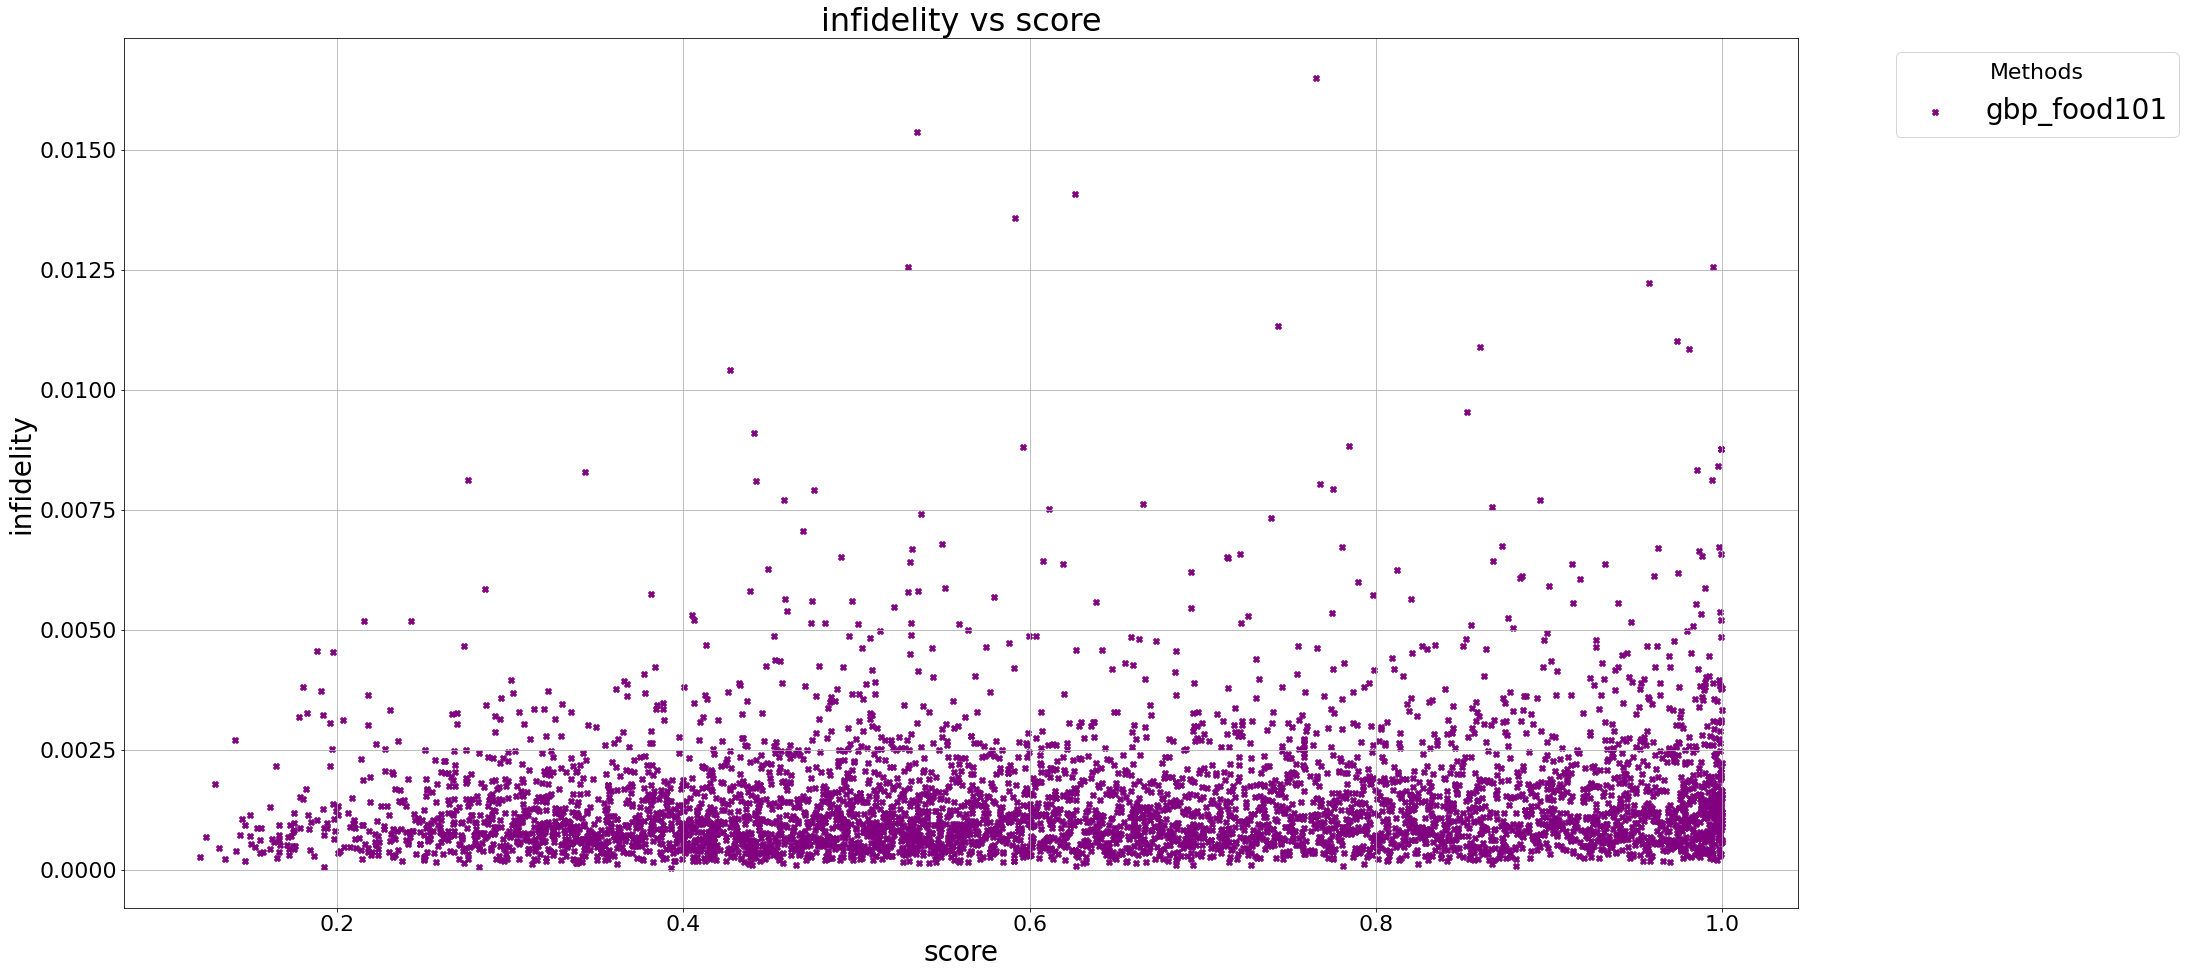

In [10]:
plt.figure(figsize=fig_size) 

datasets = [
#     'edible-plants',
    'food101',
#     'marvel',
#     'plant-data',
#     'stanford-dogs',
]
methods = [
#     'ig',
    'gbp',
#     'sailency',
#     'gradcam',
#     'deconv'
]
for dataset in datasets:
    for method in methods:
        filter_df = preds[(preds['dataset'] == dataset) & (preds['currect'] == 1.0)].sort_values(['score'])
        filter_df[f'{method}-infidelity'] = filter_df[f'{method}-infidelity'].map(lambda x: float(x))

        plt.scatter(filter_df['score'], filter_df[f'{method}-infidelity'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset)
    
plt.title('infidelity vs score', fontsize=title_font)
plt.xlabel('score', fontsize=label_font)
plt.ylabel('infidelity', fontsize=label_font)
plt.legend( title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=label_font)
plt.grid(True)
plt.show()

plt.figure(figsize=fig_size) 

for dataset in datasets:
    for method in methods:
        filter_df = preds[(preds['dataset'] == dataset) & (preds['currect'] == 0.0)].sort_values(['score'])
        filter_df[f'{method}-infidelity'] = filter_df[f'{method}-infidelity'].map(lambda x: float(x))

        plt.scatter(filter_df['score'], filter_df[f'{method}-infidelity'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset)
    
plt.title('infidelity vs score', fontsize=title_font)
plt.xlabel('score', fontsize=label_font)
plt.ylabel('infidelity', fontsize=label_font)
plt.legend( title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=label_font)
plt.grid(True)
plt.show()

In [11]:
filter_df.groupby(['score'])

In [12]:
grouped_scores = filter_df.groupby(pd.cut(filter_df["score"], np.arange(0, 1.0, 0.03))).agg([np.mean, np.std])
grouped_scores = grouped_scores.interpolate(method ='linear', limit_direction ='forward').fillna(0)
grouped_scores["score_val"] = pd.Series(grouped_scores.index, index=grouped_scores.index).map(lambda x: x.left)


In [13]:
datasets = [
    'edible-plants',
    'food101',
    'marvel',
    'plant-data',
    'stanford-dogs',
]
methods = [
#     'ig',
    'gbp',
    'sailency',
    'gradcam',
    'deconv'
]
fig_size_all = (120,80)
title_font=64
fig = plt.figure(figsize=fig_size_all) 
fig.subplots_adjust(hspace=0.15, wspace=0.1)
# fig, ax = plt.subplots(len(datasets), len(methods), sharex='col', sharey='row')
i = 0
for dataset in datasets:
    for method in methods:
        i += 1
        filter_df = preds[(preds['dataset'] == dataset) & (preds['currect'] == 1.0)].sort_values(['score'])
        filter_df[f'{method}-infidelity'] = filter_df[f'{method}-infidelity'].map(lambda x: float(x))
        grouped_scores = filter_df.groupby(pd.cut(filter_df["score"], np.arange(0, 1.0, 0.03))).agg([np.mean, np.std])
        grouped_scores = grouped_scores.interpolate(method ='linear', limit_direction ='forward').fillna(0)
        grouped_scores["score_val"] = pd.Series(grouped_scores.index, index=grouped_scores.index).map(lambda x: x.left)
        
        ax = fig.add_subplot(len(datasets), len(methods), i)
        ax.plot(grouped_scores['score_val'], grouped_scores[f'{method}-infidelity']['mean'], 
                 color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset, 
                 linewidth=2, markersize=marker_size)
        # plt.scatter(grouped_scores['score_val'], grouped_scores[f'gradcam-infidelity']['mean'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset)
        ax.axis(ymin=0, ymax=0.03 if method == "deconv" else 0.015)
        low_bound = np.array(grouped_scores[f'{method}-infidelity']['mean'] - grouped_scores[f'{method}-infidelity']['std'])
        up_bound = np.array(grouped_scores[f'{method}-infidelity']['mean'] + grouped_scores[f'{method}-infidelity']['std'])
        ax.fill_between(grouped_scores['score_val'],
                         np.clip(low_bound, 0, None), 
                         np.clip(up_bound, 0, None), 
                         color=COLORS[method], alpha=0.2)
        ax.set_xlabel('score', fontsize=label_font)
        ax.set_ylabel('infidelity', fontsize=label_font)
        ax.set_title(method+'_'+dataset)
#         ax.legend( title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=label_font)
        ax.grid(True)
plt.suptitle(f'{model} infidelity vs score - true predictions only', fontsize=title_font, y=0.92)
fig.savefig(f'../prints/{model}-infidelity vs score - true predictions only.png', bbox_inches='tight')
fig.savefig(f'../prints/{model}-infidelity vs score - true predictions only.jpg', bbox_inches='tight')
plt.show()

In [14]:
datasets = [
    'edible-plants',
    'food101',
    'marvel',
    'plant-data',
    'stanford-dogs',
]
methods = [
#     'ig',
    'gbp',
    'sailency',
    'gradcam',
    'deconv'
]
fig = plt.figure(figsize=fig_size_all) 
fig.subplots_adjust(hspace=0.15, wspace=0.1)
# fig, ax = plt.subplots(len(datasets), len(methods), sharex='col', sharey='row')
i = 0
for dataset in datasets:
    for method in methods:
        i += 1
        filter_df = preds[(preds['dataset'] == dataset) & (preds['currect'] == 0.0)].sort_values(['score'])
        filter_df[f'{method}-infidelity'] = filter_df[f'{method}-infidelity'].map(lambda x: float(x))
        grouped_scores = filter_df.groupby(pd.cut(filter_df["score"], np.arange(0, 1.0, 0.03))).agg([np.mean, np.std])
        grouped_scores = grouped_scores.interpolate(method ='linear', limit_direction ='forward').fillna(0)
        grouped_scores["score_val"] = pd.Series(grouped_scores.index, index=grouped_scores.index).map(lambda x: x.left)
        
        ax = fig.add_subplot(len(datasets), len(methods), i)

        ax.plot(grouped_scores['score_val'], grouped_scores[f'{method}-infidelity']['mean'], 
                 color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset, 
                 linewidth=2, markersize=marker_size)
        # plt.scatter(grouped_scores['score_val'], grouped_scores[f'gradcam-infidelity']['mean'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset)
        ax.axis(ymin=0, ymax=0.03 if method == "deconv" else 0.015)
        low_bound = np.array(grouped_scores[f'{method}-infidelity']['mean'] - grouped_scores[f'{method}-infidelity']['std'])
        up_bound = np.array(grouped_scores[f'{method}-infidelity']['mean'] + grouped_scores[f'{method}-infidelity']['std'])
        ax.fill_between(grouped_scores['score_val'],
                         np.clip(low_bound, 0, None), 
                         np.clip(up_bound, 0, None), 
                         color=COLORS[method], alpha=0.2)
        ax.set_xlabel('score', fontsize=label_font)
        ax.set_ylabel('infidelity', fontsize=label_font)
        ax.set_title(method+'_'+dataset)
        ax.grid(True)
plt.suptitle(f'{model} infidelity vs score - false predictions only', fontsize=title_font, y=0.92)
fig.savefig(f'../prints/{model}-infidelity vs score - false predictions only.png', bbox_inches='tight')
fig.savefig(f'../prints/{model}-infidelity vs score - false predictions only.jpg', bbox_inches='tight')
plt.show()

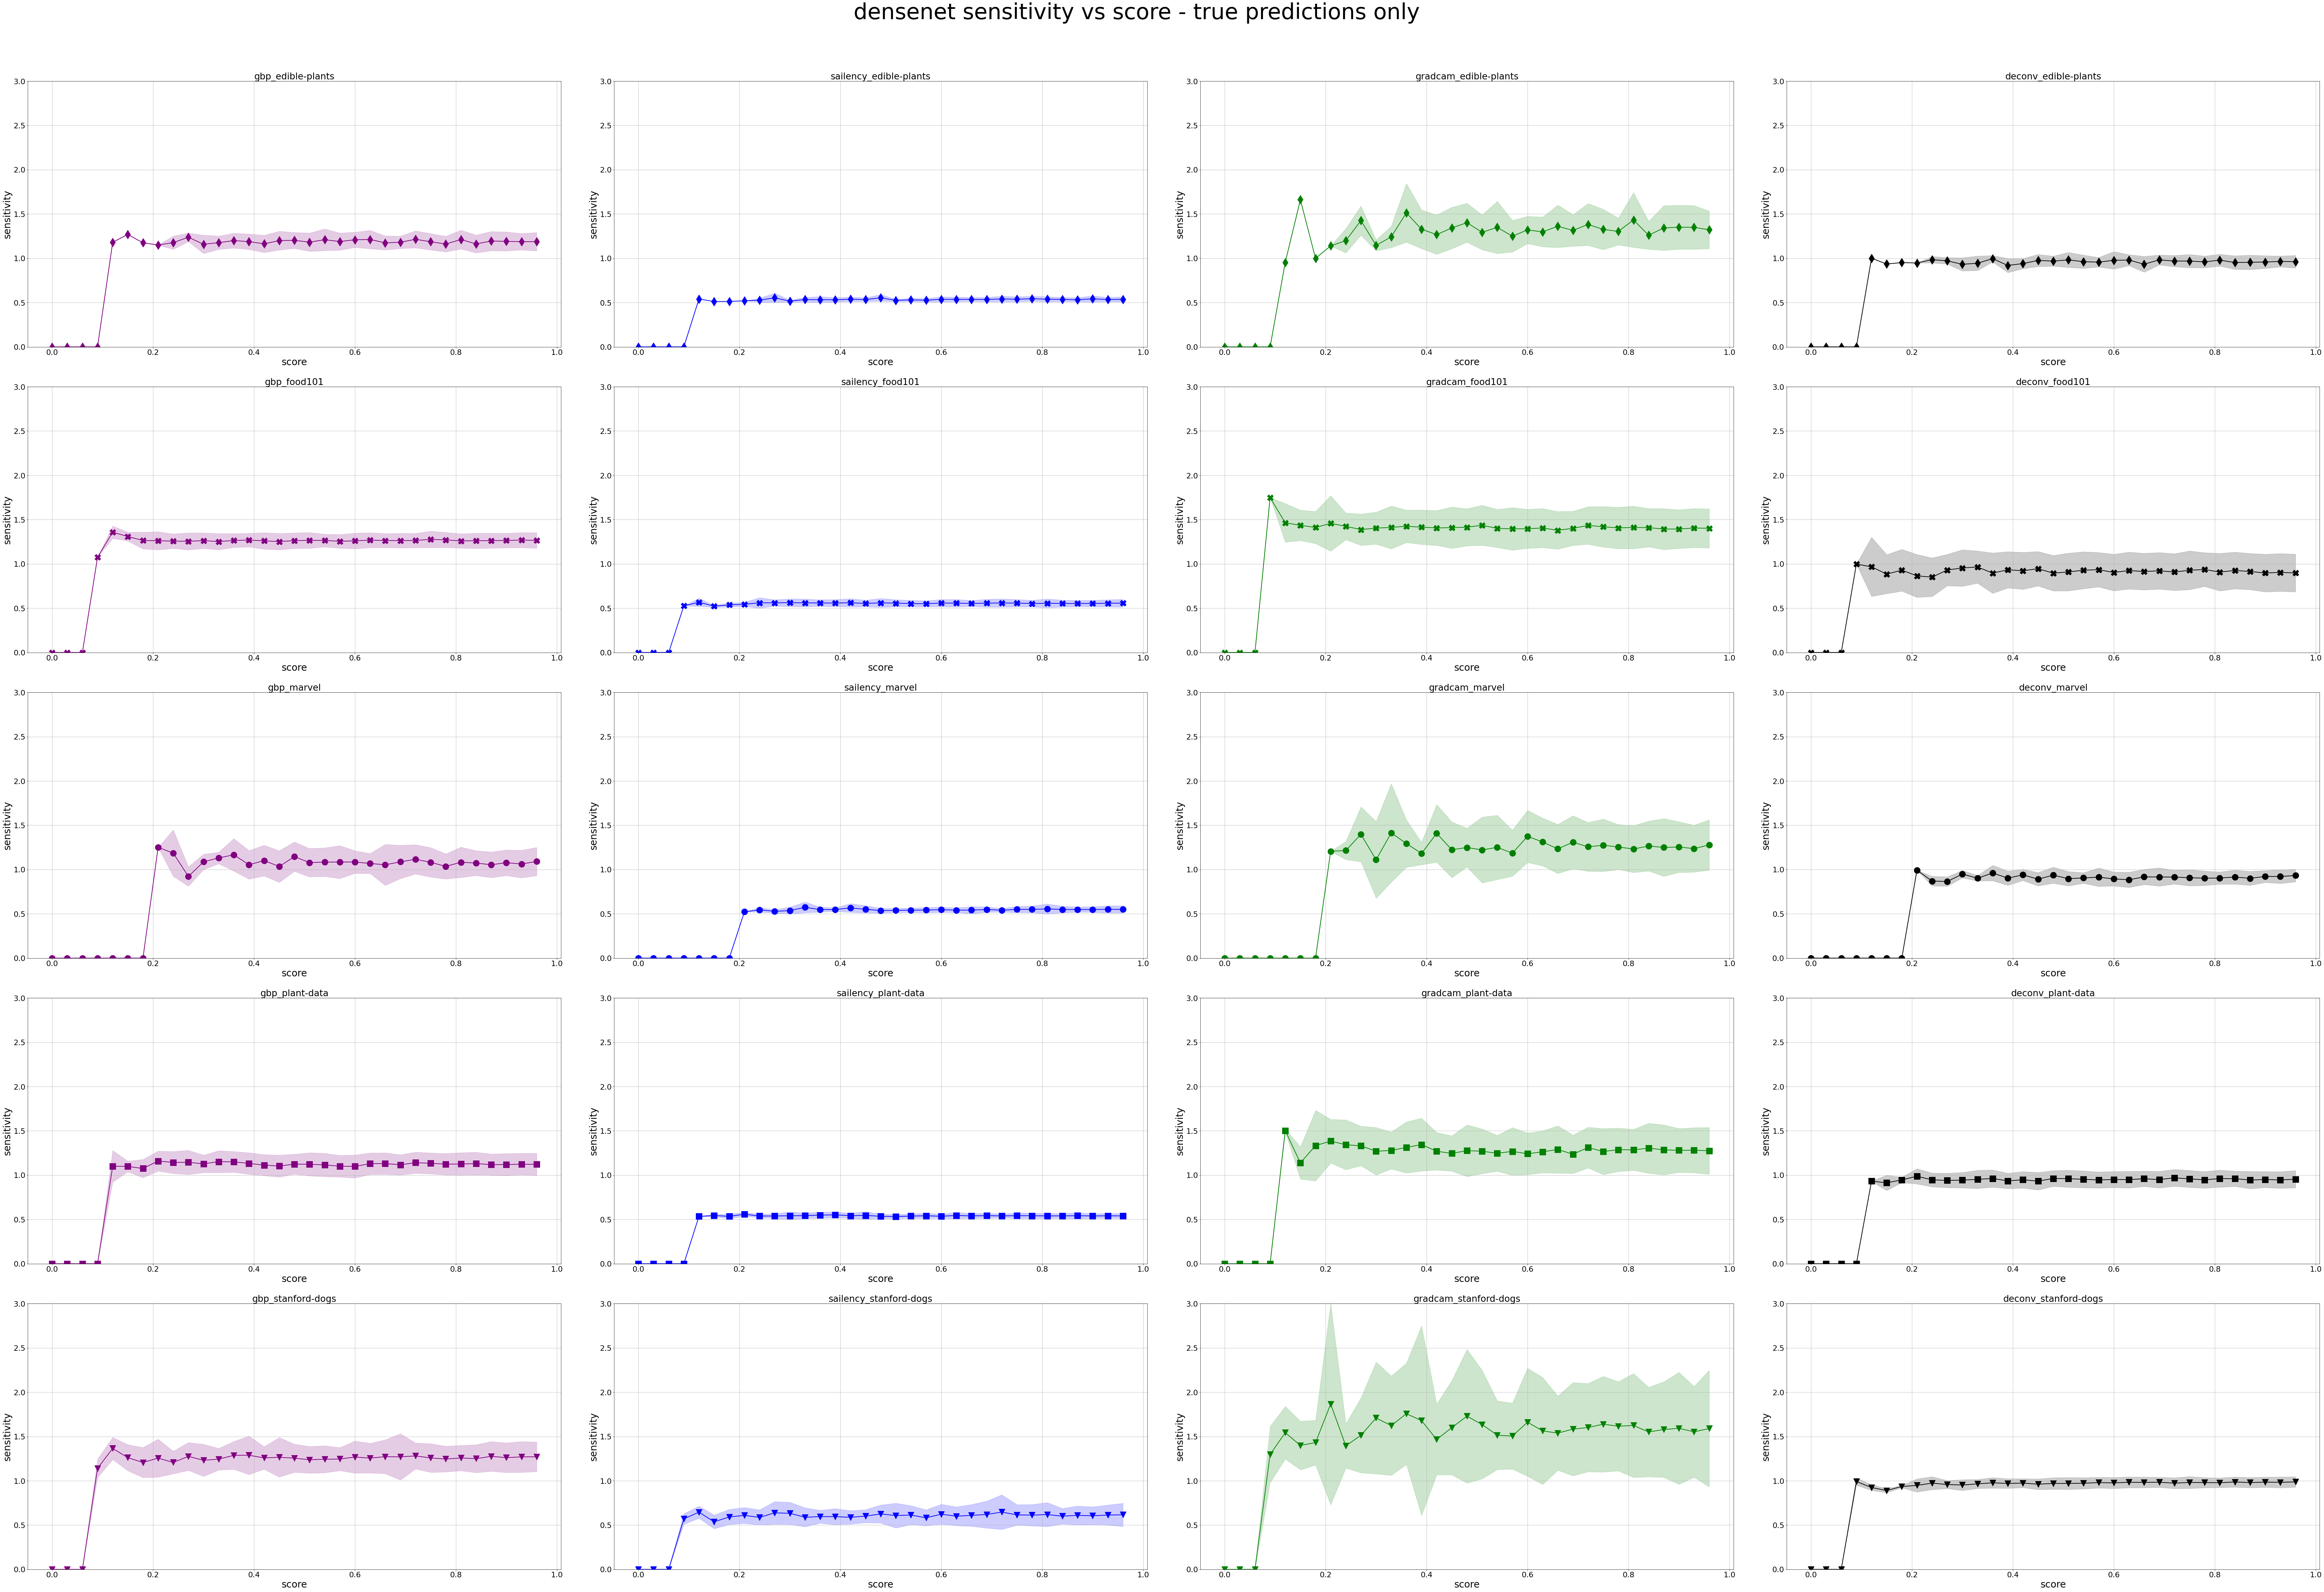

In [15]:
datasets = [
    'edible-plants',
    'food101',
    'marvel',
    'plant-data',
    'stanford-dogs',
]
methods = [
#     'ig',
    'gbp',
    'sailency',
    'gradcam',
    'deconv'
]
fig = plt.figure(figsize=fig_size_all) 
fig.subplots_adjust(hspace=0.15, wspace=0.1)
# fig, ax = plt.subplots(len(datasets), len(methods), sharex='col', sharey='row')
i = 0
for dataset in datasets:
    for method in methods:
        i += 1
        filter_df = preds[(preds['dataset'] == dataset) & (preds['currect'] == 1.0)].sort_values(['score'])
        filter_df[f'{method}-sensitivity'] = filter_df[f'{method}-sensitivity'].map(lambda x: float(x))
        grouped_scores = filter_df.groupby(pd.cut(filter_df["score"], np.arange(0, 1.0, 0.03))).agg([np.mean, np.std])
        grouped_scores = grouped_scores.interpolate(method ='linear', limit_direction ='forward').fillna(0)
        grouped_scores["score_val"] = pd.Series(grouped_scores.index, index=grouped_scores.index).map(lambda x: x.left)
        
        ax = fig.add_subplot(len(datasets), len(methods), i) 

        ax.plot(grouped_scores['score_val'], grouped_scores[f'{method}-sensitivity']['mean'], 
                 color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset, 
                 linewidth=2, markersize=marker_size)
        # plt.scatter(grouped_scores['score_val'], grouped_scores[f'gradcam-infidelity']['mean'], color=COLORS[method], marker=MARKERS[dataset], label=method+'_'+dataset)
        ax.axis(ymin=0, ymax=3.0)
        low_bound = np.array(grouped_scores[f'{method}-sensitivity']['mean'] - grouped_scores[f'{method}-sensitivity']['std'])
        up_bound = np.array(grouped_scores[f'{method}-sensitivity']['mean'] + grouped_scores[f'{method}-sensitivity']['std'])
        ax.fill_between(grouped_scores['score_val'],
                         np.clip(low_bound, 0, None), 
                         np.clip(up_bound, 0, None), 
                         color=COLORS[method], alpha=0.2)
        ax.set_xlabel('score', fontsize=label_font)
        ax.set_ylabel('sensitivity', fontsize=label_font)
        ax.set_title(method+'_'+dataset)
#         ax.legend( title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=label_font)
        ax.grid(True)
plt.suptitle(f'{model} sensitivity vs score - true predictions only', fontsize=title_font, y=0.92)
fig.savefig(f'../prints/{model}-sensitivity vs score - true predictions only.png', bbox_inches='tight')
fig.savefig(f'../prints/{model}-sensitivity vs score - true predictions only.jpg', bbox_inches='tight')
plt.show()